## Subject Selection Experiments - Srinivas (handle: thewickedaxe)
** PLEASE SCROLL TO THE BOTTOM OF THE NOTEBOOK TO FIND THE QUESTIONS AND THEIR ANSWERS**

It is now clear that without exploring feature selection and engineering the classifiers cannot process all the individuals as there is just too much noise. Therefor I am going to experiment with 2 approaches.

1. Throw out more samples till the classifiers make sense
2. Throw out more features and selct them in accordance with feature selection techniques till the classifiers make sense

This notebook will outline approach 1.

I propose 2 segregations

1. Gender: Male ADHD patients vs Male bipolar. This we already have reason to believe works by virtue of existing studies on Amen dataset
2. Race: Caucasians ADHD patients vs Caucasian Bipolar patients

Also I feel running a full gamut of classifiers is time consuming. Therefore I am limiting it to

1. LDA: Quick and Simple
2. QDA: Can handle data conditions that LDA cannot
3. Random forests: A good ensemble technique
4. Gaussian Naive bayes: A really simple and effective technique

### Initial Data Cleaning

In [125]:
# Standard
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dimensionality reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import manifold, datasets
from itertools import cycle

# Plotting tools and classifiers
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut


# Let's read the data in and clean it

def get_NaNs(df):
    columns = list(df.columns.get_values()) 
    row_metrics = df.isnull().sum(axis=1)
    rows_with_na = []
    for i, x in enumerate(row_metrics):
        if x > 0: rows_with_na.append(i)
    return rows_with_na

def remove_NaNs(df):
    rows_with_na = get_NaNs(df)
    cleansed_df = df.drop(df.index[rows_with_na], inplace=False)     
    return cleansed_df

initial_data = pd.DataFrame.from_csv('Data_Adults_1_reduced.csv')
cleansed_df = remove_NaNs(initial_data)

# Let's also get rid of nominal data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = cleansed_df.select_dtypes(include=numerics)
print X.shape

(4383, 200)


The change from last week was that we also threw out 

In [126]:
# Let's now clean columns getting rid of certain columns that might not be important to our analysis

cols2drop = ['GROUP_ID', 'doa', 'Baseline_header_id', 'Concentration_header_id',
             'Baseline_Reading_id', 'Concentration_Reading_id']
X = X.drop(cols2drop, axis=1, inplace=False)
print X.shape

# For our studies children skew the data, it would be cleaner to just analyse adults
X = X.loc[X['Age'] >= 18]
Y = X.loc[X['race_id'] == 1]
X  = X.loc[X['Gender_id'] == 1]

print X.shape
print Y.shape

(4383, 194)
(2624, 194)
(2981, 194)


we've now dropped the last of the discrete numerical inexplicable data, and removed children from the mix

### Extracting the samples we are interested in

In [127]:
# Let's extract ADHd and Bipolar patients (mutually exclusive)

ADHD_men = X.loc[X['ADHD'] == 1]
ADHD_men = ADHD_men.loc[ADHD_men['Bipolar'] == 0]

BP_men = X.loc[X['Bipolar'] == 1]
BP_men = BP_men.loc[BP_men['ADHD'] == 0]

ADHD_cauc = Y.loc[Y['ADHD'] == 1]
ADHD_cauc = ADHD_cauc.loc[ADHD_cauc['Bipolar'] == 0]

BP_cauc = Y.loc[Y['Bipolar'] == 1]
BP_cauc = BP_cauc.loc[BP_cauc['ADHD'] == 0]

print ADHD_men.shape
print BP_men.shape

print ADHD_cauc.shape
print BP_cauc.shape

# Keeping a backup of the data frame object because numpy arrays don't play well with certain scikit functions
ADHD_men = pd.DataFrame(ADHD_men.drop(['Patient_ID', 'Gender_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))
BP_men = pd.DataFrame(BP_men.drop(['Patient_ID', 'Gender_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))

ADHD_cauc = pd.DataFrame(ADHD_cauc.drop(['Patient_ID', 'race_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))
BP_cauc = pd.DataFrame(BP_cauc.drop(['Patient_ID', 'race_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))

(1056, 194)
(257, 194)
(1110, 194)
(323, 194)


we see here that there 1383 people who have ADHD but are not Bipolar and 440 people who are Bipolar but do not have ADHD

### Dimensionality reduction

#### Manifold Techniques

##### ISOMAP

In [128]:
combined1 = pd.concat([ADHD_men, BP_men])
combined2 = pd.concat([ADHD_cauc, BP_cauc])

print combined1.shape
print combined2.shape

combined1 = preprocessing.scale(combined1)
combined2 = preprocessing.scale(combined2)

(1313, 190)
(1433, 190)


In [129]:
combined1 = manifold.Isomap(20, 20).fit_transform(combined1)
ADHD_men_iso = combined1[:1056]
BP_men_iso = combined1[1056:]

combined2 = manifold.Isomap(20, 20).fit_transform(combined2)
ADHD_cauc_iso = combined2[:1110]
BP_cauc_iso = combined2[1110:]

### Clustering and other grouping experiments

#### K-Means clustering - iso

In [130]:
data1 = pd.concat([pd.DataFrame(ADHD_men_iso), pd.DataFrame(BP_men_iso)])
data2 = pd.concat([pd.DataFrame(ADHD_cauc_iso), pd.DataFrame(BP_cauc_iso)])

print data1.shape
print data2.shape

(1313, 20)
(1433, 20)


Estimated number of clusters: 2


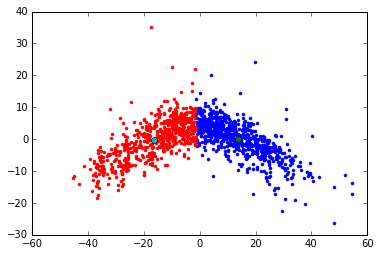

In [131]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data1.get_values())
labels1 = kmeans.labels_
centroids1 = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(centroids1))

for label in [0, 1]:
    ds = data1.get_values()[np.where(labels1 == label)]    
    plt.plot(ds[:,0], ds[:,1], '.')    
    lines = plt.plot(centroids1[label,0], centroids1[label,1], 'o')



Estimated number of clusters: 2


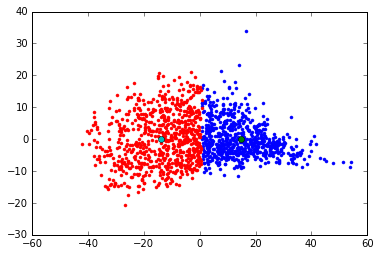

In [132]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data2.get_values())
labels2 = kmeans.labels_
centroids2 = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(centroids2))

for label in [0, 1]:
    ds2 = data2.get_values()[np.where(labels2 == label)]    
    plt.plot(ds2[:,0], ds2[:,1], '.')    
    lines = plt.plot(centroids2[label,0], centroids2[label,1], 'o')

As is evident from the above 2 experiments, no clear clustering is apparent.But there is some significant overlap and there 2 clear groups

### Classification Experiments

Let's experiment with a bunch of classifiers

In [133]:
ADHD_men_iso = pd.DataFrame(ADHD_men_iso)
BP_men_iso = pd.DataFrame(BP_men_iso)

ADHD_cauc_iso = pd.DataFrame(ADHD_cauc_iso)
BP_cauc_iso = pd.DataFrame(BP_cauc_iso)

In [139]:
BP_men_iso['ADHD-Bipolar'] = 0
ADHD_men_iso['ADHD-Bipolar'] = 1

BP_cauc_iso['ADHD-Bipolar'] = 0
ADHD_cauc_iso['ADHD-Bipolar'] = 1

data1 = pd.concat([ADHD_men_iso, BP_men_iso])
data2 = pd.concat([ADHD_cauc_iso, BP_cauc_iso])
class_labels1 = data1['ADHD-Bipolar']
class_labels2 = data2['ADHD-Bipolar']
data1 = data1.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
data2 = data2.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
data1 = data1.get_values()
data2 = data2.get_values()

In [135]:
# Leave one Out cross validation
def leave_one_out(classifier, values, labels):
    leave_one_out_validator = LeaveOneOut(len(values))
    classifier_metrics = cross_validation.cross_val_score(classifier, values, labels, cv=leave_one_out_validator)
    accuracy = classifier_metrics.mean()
    deviation = classifier_metrics.std()
    return accuracy, deviation

In [136]:
rf = RandomForestClassifier(n_estimators = 22) 
qda = QDA()
lda = LDA()
gnb = GaussianNB()
classifier_accuracy_list = []
classifiers = [(rf, "Random Forest"), (lda, "LDA"), (qda, "QDA"), (gnb, "Gaussian NB")]
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data1, class_labels1)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

Random Forest accuracy is 0.9497 (+/- 0.218)
LDA accuracy is 0.9688 (+/- 0.174)
QDA accuracy is 0.9467 (+/- 0.225)
Gaussian NB accuracy is 0.9452 (+/- 0.228)


In [137]:
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data2, class_labels2)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

Random Forest accuracy is 0.9393 (+/- 0.239)
LDA accuracy is 0.9574 (+/- 0.202)
QDA accuracy is 0.9505 (+/- 0.217)
Gaussian NB accuracy is 0.9442 (+/- 0.230)


given the number of people who have ADHD and Bipolar disorder the chance line would be at around 0.6. The classifiers fall between 0.7 and 0.75 which makes them just barely better than chance. This is still an improvement over last time.

### Questions and Answers

1) What did you separate your data into and how?<br/>

Ans: Male ADHD patients vs Male Bipolar Patients and Caucasian ADHD patients vs Caucasian Bipolar patients<br/>

2) How did you reduce dimensionality?<br/>

Ans: We used an isomap with 20 features<br/>

3) Was there any clustering apparent?<br/>

Ans: Not to me, and visually not so much<br/>

4) How did you classify and how did you validate?<br/>

Ans: I ran LDA, QDA, Random forest and Gaussian NB with leave one out cross validation<br/>

5) What were the results?<br/>

Ans: Male study<br/>
Random Forest accuracy is 0.9497 (+/- 0.218)<br/>
LDA accuracy is 0.9688 (+/- 0.174)<br/>
QDA accuracy is 0.9467 (+/- 0.225)<br/>
Gaussian NB accuracy is 0.9452 (+/- 0.228)<br/>

Race Study<br/>
Random Forest accuracy is 0.9393 (+/- 0.239)<br/>
LDA accuracy is 0.9574 (+/- 0.202)<br/>
QDA accuracy is 0.9505 (+/- 0.217)<br/>
Gaussian NB accuracy is 0.9442 (+/- 0.230)<br/>